Units used: GeV for masses, s for time, cm for distances

In [45]:
import os
import glob
import importlib

import matplotlib as mlib
import matplotlib.pyplot as plt

# plt.rcParams["text.usetex"] = True
# plt.rcParams["text.latex.preamble"] = r"\usepackage{slashed}"

import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy
import scipy.integrate as integrate
import scipy.optimize as optimize

import csv

In [46]:
#Plotting settings

font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [47]:
def importNotebook(name):
    
    currentDir=os.getcwd()
    notebookDir=os.path.dirname(name)
    os.chdir(notebookDir)
    notebookName=os.path.basename(name).split('.')[0]
    module = importlib.import_module(f"ipynb.fs.full.{notebookName}")
    
    os.chdir(currentDir)
    
    globals().update(vars(module))

In [48]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_base.ipynb")

In [49]:
importNotebook("/home/stasya/prj/alps/Python/ALPs_BRs.ipynb")

In [50]:
def getCsd(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return -coeffs['D'][1][0]+coeffs['d'][1][0]

### mass-coupling grid

In [51]:
#masslist= [0.05, 0.05, 0.1, 0.2, 0.3, 0.5, 1., 2., 4.]
masslist=np.sort(np.append(np.logspace(-2, 0, 25),[0.09, 0.101, 0.43, 0.47,0.55,\
                                                   0.95, 1, 1.5, 2, 2.5, 3, 3.2, 3.5, 4,\
                                                   0.0935, 0.095, 0.63, 0.65]))
masslistShort=np.logspace(-2,np.log(2.1), 40)
particleCodes=[*range(0,7,1)]

In [52]:
masslistShort

array([0.01      , 0.01175726, 0.01382331, 0.01625243, 0.0191084 ,
       0.02246624, 0.02641414, 0.03105579, 0.0365131 , 0.0429294 ,
       0.0504732 , 0.05934265, 0.06977069, 0.08203121, 0.09644622,
       0.11339432, 0.13332063, 0.15674852, 0.1842933 , 0.2166784 ,
       0.25475441, 0.29952136, 0.35215502, 0.41403778, 0.48679494,
       0.57233742, 0.67291193, 0.79115999, 0.93018729, 1.09364529,
       1.28582709, 1.51178022, 1.77743916, 2.08978126, 2.45700995,
       2.88877024, 3.396402  , 3.9932378 , 4.69495311, 5.51997797])

In [53]:
couplingList=np.sort(np.append(np.logspace(-6, 4, 20),np.logspace(-1, 2, 20)))
couplingListShort=np.logspace(np.log(8*10**-4), np.log(1.7), 25)

In [54]:
couplingListShort

array([7.39777588e-08, 1.54287757e-07, 3.21782010e-07, 6.71107442e-07,
       1.39965935e-06, 2.91912468e-06, 6.08811630e-06, 1.26973542e-05,
       2.64815579e-05, 5.52298451e-05, 1.15187173e-04, 2.40233968e-04,
       5.01031130e-04, 1.04494879e-03, 2.17934156e-03, 4.54522719e-03,
       9.47951003e-03, 1.97704332e-02, 4.12331468e-02, 8.59957079e-02,
       1.79352350e-01, 3.74056638e-01, 7.80131225e-01, 1.62703897e+00,
       3.39334683e+00])

In [55]:
constants={
    'InvGeVtocm': 1/(5.06 * 10**(13))
}

In [56]:
sm['tauK+'] = 1.238*10**(-8)

In [57]:
def f(Lambda):
    return Lambda/(4 * np.pi)

In [58]:
def formFactorFzeroKplus(qsqr): 
    #https://indico.cern.ch/event/769729/contributions/3512047/attachments/1905114/3146148/Kaon2019_MoulsonPassemarCorr.pdf
    l01 = 25.17
    l02 = 1.49
    f0 = 1.0012 * 0.216 #Christopher Smith's notes & 2107.14708
    return f0 * (1 + l01 * (qsqr/sm['mpi+']) + l02 * (qsqr/sm['mpi+'])**2) 
            #fplus(qsqr) + qsqr/(sm['mK+']**2-sm['mpi+']**2) fminus(qsqr)

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

### ALP and B-> Ka decay rates

In [59]:
# as in draft
def BrBtoKaplus(ma, cbs, Lambda):
    return (np.pi/4)*abs(cbs)**2/(Lambda**2) * abs(formFactorFzeroBplus(ma))**2 \
            * (sm['mB+']**2-sm['mK+']**2)**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4\
            -2*(sm['mB+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))\
            /sm['hbar']*sm['tauB+']

In [60]:
# as in draft
def BrKtoPiaplus(ma, csd, Lambda):
    return (np.pi/4)* abs(csd)**2/(Lambda**2) * abs(formFactorFzeroKplus(ma))**2 \
            * (sm['mK+']**2-sm['mpi+']**2)**2/sm['mK+']**3 * np.sqrt(sm['mK+']**4+sm['mpi+']**4+ma**4\
            -2*(sm['mpi+']**2 * sm['mK+']**2 + sm['mK+']**2 * ma**2 + ma**2 * sm['mpi+']**2))\
            /sm['hbar']*sm['tauK+']

### ALP branching ratios

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

In [61]:
def brALPtoOneFinalState(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        brs = [[],[],[],[],[],[],[],[],[]]
        
        if (lscsPassed is not None):
            lscs=lscsPassed
        else:
            if ma<1:
                mu = 1
            else:
                mu=ma
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)
        
#         print("mu= ",mu)
#         print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
#         print([ma,readCee(lscs),sm['me'],Lambda])
#         print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        
        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])
            

#         print("br[0][-1]= ",brs[0][-1])
        
        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

In [62]:
def brALPtoOneFinalStateCheck(ma,finalStateCode,cQ,cu,cd,cL,ce,cGG,cWW,cBB,Lambda,lscsPassed=None,looporder=3,br=True):
#     with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = -np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = -np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = -np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

#         maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
        brs = [[],[],[],[],[],[],[],[],[]]
        if ma<1:
            mu = 1
        else:
            mu=ma
        lscs = TdAlps.RunRotateMatchRun(HC, Lambda, mu, looporder)
        print("mu= ",mu)
        print("readCee= ",readCee(lscs),", readCmumu= ",readCmumu(lscs))
        print([ma,readCee(lscs),sm['me'],Lambda])
        print("Gamma_ll= ",Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))

        brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
        brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
        try:
            ctautau = readCtautau(lscs)
        except IndexError:
            ctautau = 0
        brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
        try:
            ccc = readCcc(lscs)
        except IndexError:
            ccc = 0
        brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
        try:
            cbb = readCbb(lscs)
        except IndexError:
            cbb = 0
        brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
        brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
        brs[6].append(Gammaatohad(ma,lscs,Lambda))
        brs[7].append(Gammaato3pi000(ma,lscs,Lambda)+Gammaato3pi0pm(ma,lscs,Lambda))
        brs[8].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]\
                      +brs[6][-1]+brs[7][-1])

        print("br[0][-1]= ",brs[0][-1])

        ctauAlp=constants['InvGeVtocm']/brs[8][-1]

        return [brs[finalStateCode][-1]/brs[8][-1],ctauAlp]

In [63]:
brALPtoOneFinalState(0.1,5,1,-1,-1,1,-1,0,0,0,4*np.pi*4*np.pi*10**3,lscsPassed=None)

/home/stasya/prj/alps-running/TdAlps-Internal/HighRunning.py:108: RuntimeWarning: invalid value encountered in sqrt
  g1 = np.sqrt(5 / 3 * a1 * (4 * p['PI']))


[0.8875352720262125, 10487150925.033693]

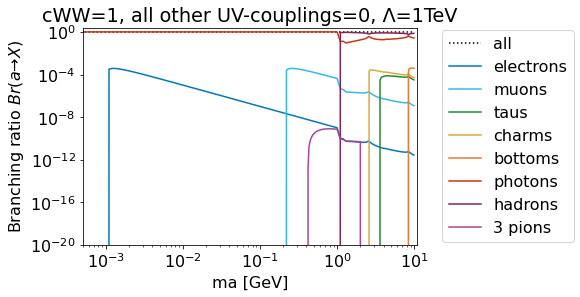

In [64]:
brsALP(0,0,0,0,0,0,1,0,"cWW=1, all other UV-couplings=0, \u039B=1TeV",1000,lower=10**-20)

### decays under consideration encoded as
 - 0: e 
 - 1: mu
 - 2: tau
 - 3: charm
 - 4: bottom
 - 5: photon
 - 6: hadron
 - 7: 3 pions

## Generate [ma, tau, c, BR(theory)] files for Na62

In [65]:
Na62Bounds=genfromtxt('../Experimental_files/Na62-BR_m_tau_2103.15389-h.csv', delimiter=',')

In [66]:
masslist

array([0.01      , 0.01211528, 0.01467799, 0.01778279, 0.02154435,
       0.02610157, 0.03162278, 0.03831187, 0.04641589, 0.05623413,
       0.06812921, 0.08254042, 0.09      , 0.0935    , 0.095     ,
       0.1       , 0.101     , 0.12115277, 0.14677993, 0.17782794,
       0.21544347, 0.26101572, 0.31622777, 0.38311868, 0.43      ,
       0.46415888, 0.47      , 0.55      , 0.56234133, 0.63      ,
       0.65      , 0.68129207, 0.82540419, 0.95      , 1.        ,
       1.        , 1.5       , 2.        , 2.5       , 3.        ,
       3.2       , 3.5       , 4.        ])

In [67]:
Na62Bounds[:,0]* 10**-3

array([0.   , 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  , 0.11 , 0.154, 0.156, 0.158, 0.16 , 0.162, 0.164,
       0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178, 0.18 , 0.182,
       0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196, 0.198, 0.2  ,
       0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214, 0.216, 0.218,
       0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232, 0.234, 0.236,
       0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 , 0.252, 0.254,
       0.256, 0.258, 0.26 ])

In [68]:
couplingListSmallCouplings=np.sort(np.append(np.logspace(-7, 4, 20),np.logspace(-1, 2, 20)))

In [69]:
couplingListSmallCouplings

array([1.00000000e-07, 3.79269019e-07, 1.43844989e-06, 5.45559478e-06,
       2.06913808e-05, 7.84759970e-05, 2.97635144e-04, 1.12883789e-03,
       4.28133240e-03, 1.62377674e-02, 6.15848211e-02, 1.00000000e-01,
       1.43844989e-01, 2.06913808e-01, 2.33572147e-01, 2.97635144e-01,
       4.28133240e-01, 6.15848211e-01, 8.85866790e-01, 8.85866790e-01,
       1.27427499e+00, 1.83298071e+00, 2.63665090e+00, 3.35981829e+00,
       3.79269019e+00, 5.45559478e+00, 7.84759970e+00, 1.12883789e+01,
       1.27427499e+01, 1.62377674e+01, 2.33572147e+01, 3.35981829e+01,
       4.83293024e+01, 4.83293024e+01, 6.95192796e+01, 1.00000000e+02,
       1.83298071e+02, 6.95192796e+02, 2.63665090e+03, 1.00000000e+04])

In [70]:
def generateNa62Files(mlist,clist,process,Lambda):
    
    with HiddenPrints():
    
        Na62List=[['# m [GeV], tau [ps], c, BR_theo(K+->pi+ a)\n']]

        for ma in mlist:
            for c in clist:

#                 if process in ['cff=cWW=cBB']:
#                     #print("1")
#                     cQ=cL=cWW=cBB=cff=c
#                     ce=cd=cu=-c
#                     cGG=0

                if process in ['cWW']:
                    #print("2")
                    cQ=cL=cu=cd=ce=cGG=cBB=cff=0
                    cWW=c


                if process in ['cff']:
                    #print("3")
                    cGG=cWW=cBB=0
                    cQ=cL=cff=c
                    ce=cd=cu=c

#                 coefs=getLScoefficients(cff, cWW, cBB, Lambda, ma)

                csd=getCsd(cff, cWW, cBB, Lambda, sm['mB+'])
    
#                 print(csd)

                BR= BrKtoPiaplus(ma, csd, Lambda)
                tau=ctaua(ma, cff, cWW, cBB, Lambda)/sm['c']*10**12

                Na62List.append([ma,tau,c,BR])
        return Na62List

In [71]:
meshcWW=generateNa62Files(Na62Bounds[:,0] * 10**-3,couplingListSmallCouplings,'cWW',4*np.pi*10**3)
meshcff=generateNa62Files(Na62Bounds[:,0] * 10**-3,couplingListSmallCouplings,'cff',4*np.pi*10**3)

In [72]:
# with open("output/m-tau-c-BRBtoKmumu-cffcWWcBB.dat", "w", newline="") as f:
#     writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
#     writer.writerows(meshcffcWWcBB)
    
with open("output/m-tau-c-BRKtoPia-cWW.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcWW)
    
with open("output/m-tau-c-BRKtoPia-cff.dat", "w", newline="") as f:
    writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
    writer.writerows(meshcff)

### interpolating Na62 files in lifetime and comparing to theo files

In [73]:
tauListNa62 = 10**12*np.array([np.Inf, 5*10**-9, 2*10**-9, 1*10**-9, 500*10**(-12), 200*10**(-12),\
                      100*10**(-12),]) # [tau] = ps

In [74]:
tauListNa62

array([  inf, 5000., 2000., 1000.,  500.,  200.,  100.])

In [75]:
def compareTheoExp(coupling):
    theoList = genfromtxt('output/m-tau-c-BRKtoPia-{}.dat'.format(coupling), delimiter=',')
#     print(theoList[0])
    
    allowedlist=[['# m [GeV], tau [ps], c, BR_theo(K+->pi+ a), BR_Na62(K+->pi+ a), Allowed/excluded (1/0)\n']]
    for i in range(0,theoList.shape[0]):
        #picking mass and tau from theo file
        ma = theoList[i,0]
        taua = theoList[i,1]
        
        # finding the same mass in exp file
        expPosition=np.where((Na62Bounds[:,0]/1000 >= ma*(1-0.0001))&(Na62Bounds[:,0]/1000 <= ma*(1+0.0001)))
    
        #interpolating BRexp so we get it for tau from out theo file
        BRexp=np.interp(taua,tauListNa62,Na62Bounds[expPosition,1:][0,0])

        # comparing theo and exp bounds (1 = allowed, 0 = excluded)
        if BRexp<=theoList[i,3]:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,0])
        else:
            allowedlist.append([theoList[i,0],theoList[i,1],theoList[i,2],theoList[i,3],BRexp,1])

        # writing results into a file
        with open("output/m-tau-c-BRKtoPia-{}_combined.dat".format(coupling), "w", newline="") as f:
            writer = csv.writer(f,delimiter=",", quoting = csv.QUOTE_NONE,escapechar=' ')
            writer.writerows(allowedlist)
        

In [76]:
compareTheoExp("cWW")
compareTheoExp("cff")

### importing bounds 

In [77]:
Na62BoundscWW = genfromtxt('output/m-tau-c-BRKtoPia-cWW_combined.dat', delimiter=',')
Na62Boundscff = genfromtxt('output/m-tau-c-BRKtoPia-cff_combined.dat', delimiter=',')

In [78]:
Na62BoundscWW

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 4.99267819e-24,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.79269019e-07, 7.18171738e-23,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.43844989e-06, 1.03305406e-21,
        2.02000000e-10, 1.00000000e+00],
       ...,
       [2.60000000e-01, 1.80003472e-03, 6.95192796e+02, 4.18815359e-01,
        1.24000000e-10, 0.00000000e+00],
       [2.60000000e-01, 1.25090559e-04, 2.63665090e+03, 6.02248612e+00,
        1.24000000e-10, 0.00000000e+00],
       [2.60000000e-01, 8.69735546e-06, 1.00000000e+04, 8.67625758e+01,
        1.24000000e-10, 0.00000000e+00]])

In [79]:
Na62Boundscff

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e-07, 4.90657238e-19,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.79269019e-07, 7.05785850e-18,
        2.02000000e-10, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.43844989e-06, 1.01523758e-16,
        2.02000000e-10, 1.00000000e+00],
       ...,
       [2.60000000e-01, 6.74673599e-07, 6.95192796e+02, 4.13273478e+04,
        1.24000000e-10, 0.00000000e+00],
       [2.60000000e-01, 4.69028226e-08, 2.63665090e+03, 5.94473189e+05,
        1.24000000e-10, 0.00000000e+00],
       [2.60000000e-01, 3.26065044e-09, 1.00000000e+04, 8.55119892e+06,
        1.24000000e-10, 0.00000000e+00]])

### plots

In [80]:
def fromLambdatof(inputarray):
    tmp=inputarray.copy()
    tmp[:,1] *= 4*np.pi
    return tmp

In [81]:
def plotBounds(boundsArray, particleCode, upper=False):
    if upper:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,1]]).T
    else:
        return np.vstack([np.array(masslist),boundsArray[:,particleCode,0]]).T

In [82]:
def stackBounds(xarray,arrSmattToLarge,arrLargeToSmall):
    combinedx=np.append(xarray,np.flip(xarray))
    combinedy=np.append(arrSmattToLarge,np.flip(arrLargeToSmall))
    
    return np.vstack([combinedx,combinedy]).T

In [83]:
def plotGen(inputarray,lineScatterFillORPolygon,color,linewidthORmarkersize,*args,**kwargs):
    
    data=inputarray[~np.isnan(inputarray[:,1])]
    
    if not args:
        alphaPoly=0.3
    else:
        alphaPoly=args[0]
    
    if (lineScatterFillORPolygon=="polygon"):
        ax.fill(data[:,0],data[:,1], color=color, alpha=1,**kwargs)
    if (lineScatterFillORPolygon=="oppacpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor=color,alpha=alphaPoly,\
                edgecolor=color,linewidth=linewidthORmarkersize,**kwargs)
    if (lineScatterFillORPolygon=="nonfilledpolygon"):
        ax.fill(data[:,0],data[:,1], facecolor="none", edgecolor=color,\
                linewidth=linewidthORmarkersize, linestyle='-',**kwargs)
        
def plotAllowed(inputfile,x,y,z,zfixed):
    inputparams = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    #choosing only rows with z=zfixed
    zfixedonly=inputparams[:,z]==zfixed
    params=inputparams[zfixedonly]

    allowed=params[:,5]==1

    plt.scatter(params[allowed,x], params[allowed,y], c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y], c='red')
    
def plotAllAllowed(inputfile,x,y):
    params = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    allowed=params[:,5]==1
    
    
    plt.scatter(params[allowed,x], params[allowed,y], c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y], c='red')
    
def plotAllAllowedConverted(inputfile,x,y):
    params = np.array(genfromtxt(inputfile,  comments="#", delimiter=','))
    
    allowed=params[:,5]==1
    
    
    plt.scatter(params[allowed,x], params[allowed,y]*(4*np.pi), c='green')
    plt.scatter(params[~allowed,x], params[~allowed,y]*(4*np.pi), c='red')
    
# function that plots cut-out regions from 2103.15389

def whiteregions(m):
    return np.heaviside(m - 0.110,0)*np.heaviside(-m + 0.154,0)

def plotWhiteRegions(yupper):
    m=np.linspace(0.05,0.3,num=10000);
    plt.fill_between(m,(whiteregions(m))*yupper,0,color="black",zorder=4)

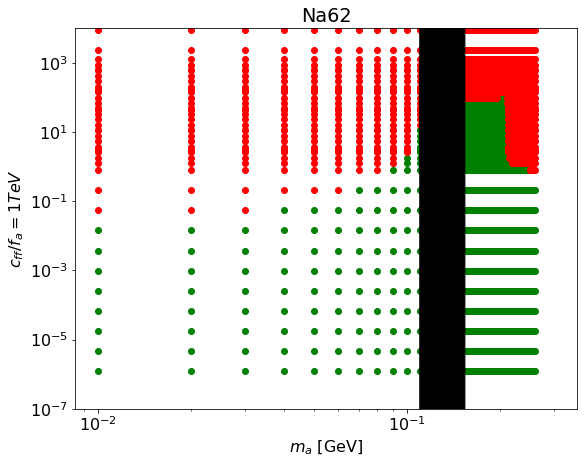

In [84]:
plt.figure(figsize=(9, 7))


plotAllAllowedConverted("output/m-tau-c-BRKtoPia-cff_combined.dat",0,2)
#plotWhiteRegions(10**(3))

plotWhiteRegions(10**5)

plt.title('Na62')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{ff}/f_a=1 TeV$')
plt.xscale("log")
plt.yscale("log")

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.savefig('plots/Na62_cff_bound_new.png', dpi=300, bbox_inches='tight')

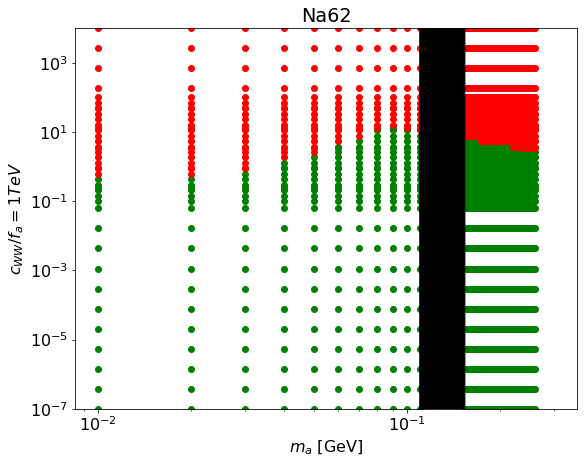

In [85]:
plt.figure(figsize=(9, 7))


plotAllAllowed("output/m-tau-c-BRKtoPia-cWW_combined.dat",0,2)
plotWhiteRegions(10**(5))

plt.title('Na62')
plt.xlabel('$m_a$ [GeV]')
#plt.xlim(0.2,0.2)
plt.ylabel('$c_{WW}/f_a=1 TeV$')

# plt.xlim(9*10**-3, 4)
plt.ylim(10**-7, 10**4)

plt.xscale("log")
plt.yscale("log")

plt.savefig('plots/Na62_cWW_bound_new.png', dpi=300, bbox_inches='tight')

# Combined plots